# AR, MA, ARIMA, SARIMA, SARIMAX

## Definition

ARIMA, short for ‘Auto Regressive Integrated Moving Average’ is actually a class of models that ‘explains’ a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. Know more about parameters of ARIMA and its limitations, in this free video tutorial

Any ‘non-seasonal’ time series that exhibits patterns and is not a random white noise can be modeled with ARIMA models.

An ARIMA model is characterized by 3 terms: $p, d, q$

where,

- $p$ is the order of the AR term, it refers to the number of lags of Y to be used as predictors.
- $q$ is the order of the MA term, it refers to the number of lagged forecast errors that should go into the ARIMA Model.
- $d$ is the number of differencing required to make the time series stationary

If a time series, has seasonal patterns, then you need to add seasonal terms and it becomes SARIMA, short for Seasonal ARIMA. More on that once we finish ARIMA.

## AR

$$Y_t=\sum_{i=1}^{p}\phi_i Y_{t-i}+\epsilon_t$$

## MA

$$Y_t=\epsilon_t+\sum_{i=1}^{q}\theta_i \epsilon_{t-i}$$

## ARMA

$$Y_t=\sum_{i=1}^{p}\phi_i Y_{t-i}+\epsilon_t+\sum_{i=1}^{q}\theta_i \epsilon_{t-i}$$

## ARIMA

$$Y_t'=\sum_{i=1}^{p}\phi_i Y_{t-i}'+\epsilon_t+\sum_{i=1}^{q}\theta_i \epsilon_{t-i}$$
where $'$ is the derivative order : $d$.


In [3]:
from warnings import filterwarnings

filterwarnings("ignore")

import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

from quant_invest_lab.data_provider import download_crypto_historical_data

In [4]:
symbol = "BTC-USDT"

df_BTC = download_crypto_historical_data(symbol, "1day").loc["2020-11-20":]

df_BTC["Log_Close"] = np.log(df_BTC.Close.apply(lambda x: 1.0 if x == 0.0 else x))
df_BTC["Returns"] = df_BTC.Close.pct_change()
df_BTC["Log_Returns"] = df_BTC.Log_Close.pct_change()
df_BTC["Log_Volume"] = np.log(
    np.abs(df_BTC.Volume.apply(lambda x: 1.0 if x == 0.0 else x))
)
df_BTC["Vol20"] = df_BTC.Log_Returns.rolling(20).std()
df_BTC["EMA20"] = df_BTC.Close.ewm(20).mean()


df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

(890, 13)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Log_Close,Log_Returns,Log_Volume,Vol20,EMA20
Date,,,,,,,,,,,,,
2020-12-10 01:00:00,1.607558e+09,18540.0,18251.2,18552.2,17913.4,1255.370680,2.292105e+07,-0.015582,9.811986,-0.001598,16.947566,0.003780,18649.510967
2020-12-11 01:00:00,1.607645e+09,18251.4,18027.0,18288.9,17584.2,1845.597719,3.304855e+07,-0.012284,9.799626,-0.001260,17.313488,0.003788,18604.470515
2020-12-12 01:00:00,1.607731e+09,18035.9,18806.8,18942.1,18020.9,968.568285,1.792373e+07,0.043257,9.841974,0.004321,16.701636,0.003902,18618.756291
2020-12-13 01:00:00,1.607818e+09,18809.8,19176.1,19411.0,18715.0,1285.871491,2.465229e+07,0.019637,9.861420,0.001976,17.020380,0.003923,18657.224101
2020-12-14 01:00:00,1.607904e+09,19176.1,19271.1,19348.2,19002.2,830.182795,1.591667e+07,0.004954,9.866362,0.000501,16.582877,0.003808,18698.706009


## Finding params

### Checking stationary (finding $d$)


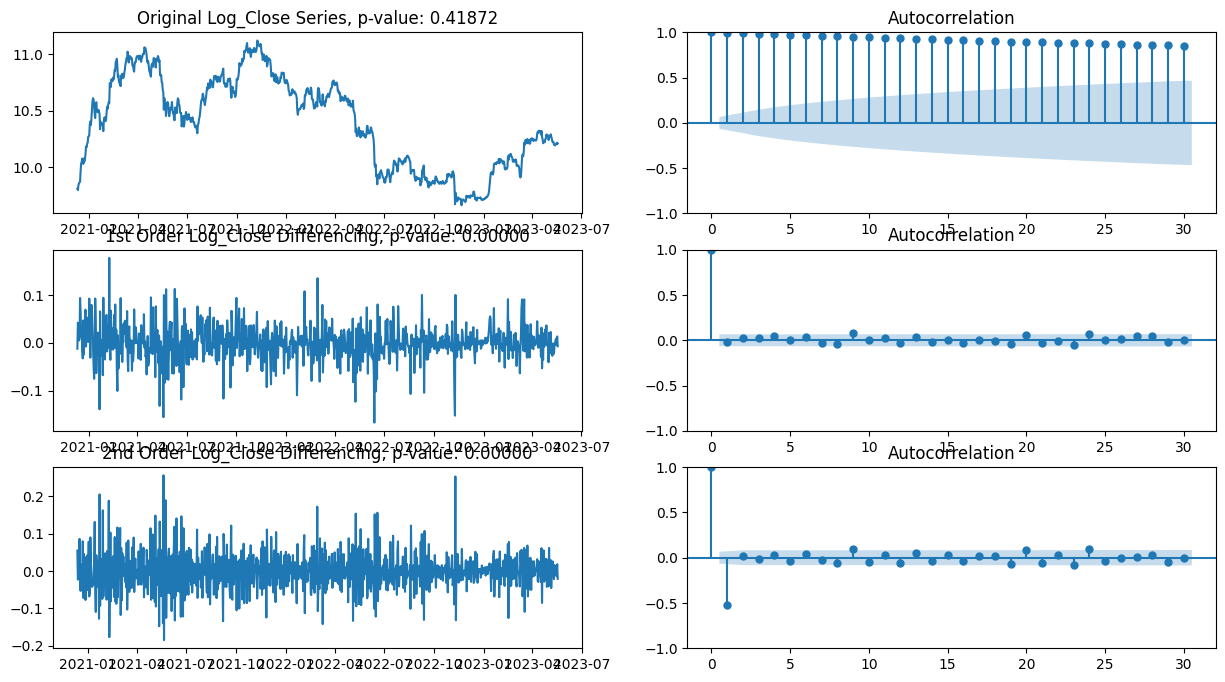

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

serie = "Log_Close"

# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes[0, 0].plot(df_BTC.index, df_BTC[serie])
axes[0, 0].set_title(
    f"Original {serie} Series, p-value: {adfuller(df_BTC[serie].values)[1]:.5f}"
)
plot_acf(df_BTC[serie], ax=axes[0, 1])

# 1st Differencing
diff = df_BTC[serie].diff().dropna()
axes[1, 0].plot(diff.index, diff)
axes[1, 0].set_title(
    f"1st Order {serie} Differencing, p-value: {adfuller(diff.values)[1]:.5f}"
)
plot_acf(diff.dropna(), ax=axes[1, 1])

# 2nd Differencing
diff_diff = diff.diff().dropna()
axes[2, 0].plot(diff_diff.index, diff_diff)
axes[2, 0].set_title(
    f"2nd Order {serie} Differencing, p-value: {adfuller(diff_diff.values)[1]:.5f}"
)
plot_acf(diff_diff.dropna(), ax=axes[2, 1])

plt.show()


No derivative is enough to be stationary.


### Finding $p$


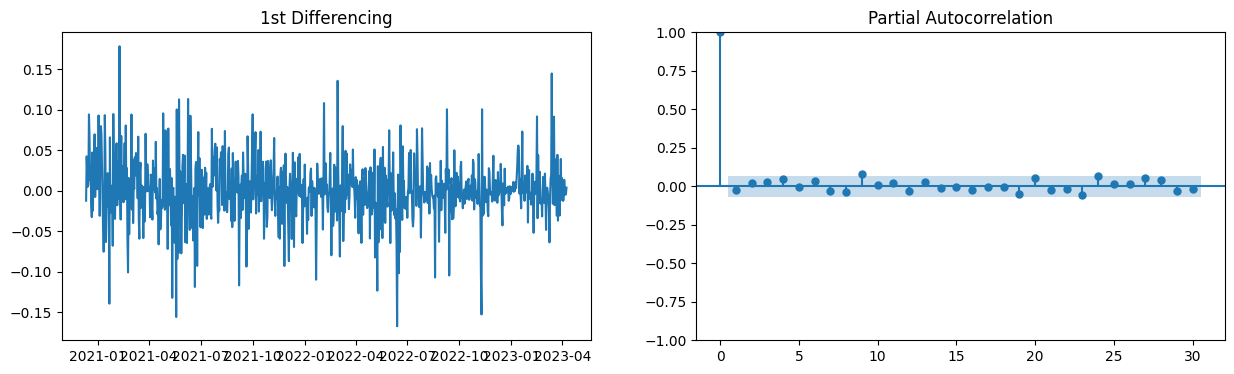

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(diff.index, diff.values)
axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0, 5))
plot_pacf(diff, ax=axes[1])

plt.show()

You can observe that the PACF lag 1 is quite significant since is well above the significance line.

### Finding $q$


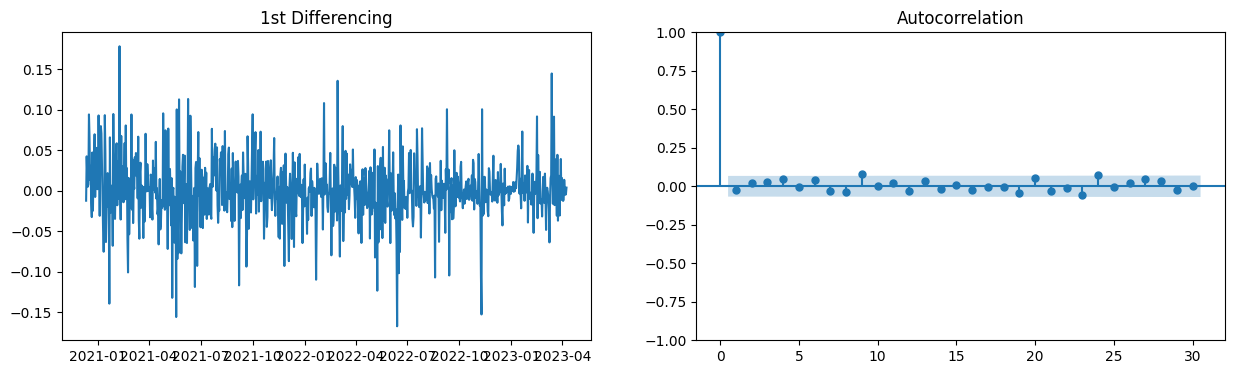

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(diff.index, diff.values)
axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0, 5))
plot_acf(diff, ax=axes[1])

plt.show()

You can observe that the ACF lag 1 is quite significant since is well above the significance line.


## ARIMA Modeling


In [23]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_BTC[serie].values, order=(6, 1, 2))  # (p, d, q)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  850
Model:                 ARIMA(6, 1, 2)   Log Likelihood                1586.870
Date:                Sat, 08 Apr 2023   AIC                          -3155.740
Time:                        23:46:02   BIC                          -3113.044
Sample:                             0   HQIC                         -3139.385
                                - 850                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0114      0.838     -0.014      0.989      -1.655       1.632
ar.L2          0.0091      0.905      0.010      0.992      -1.765       1.783
ar.L3          0.0277      0.043      0.648      0.5

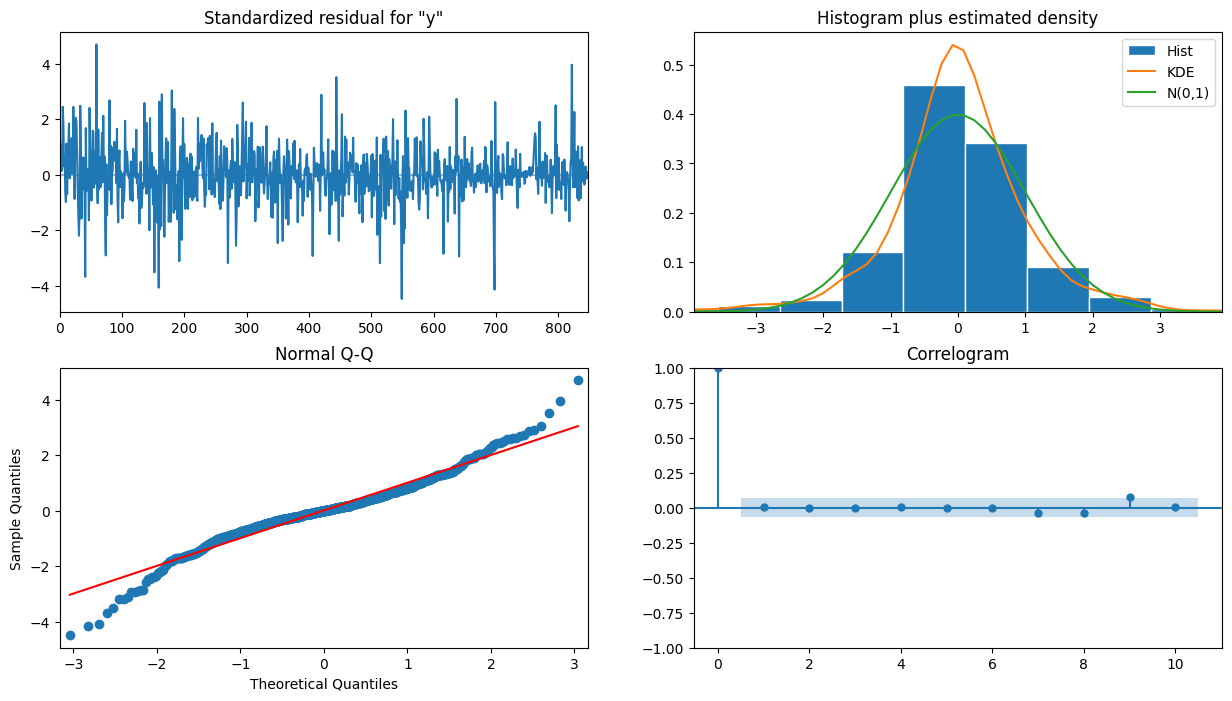

In [24]:
model_fit.plot_diagnostics(figsize=(15, 8))
plt.show()


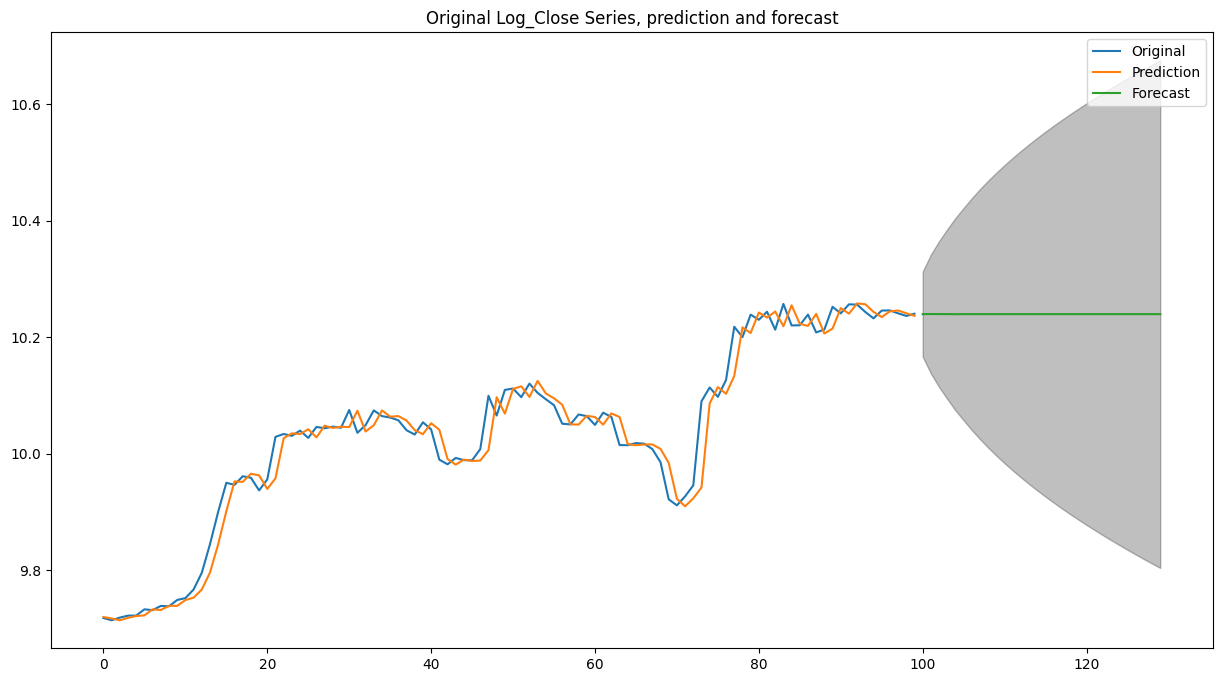

In [25]:
df_to_plot = df_BTC.iloc[-100:]
fitted = model_fit.fittedvalues[-100:]
steps = 30
forecasted = model_fit.get_forecast(steps=steps)


fig, axes = plt.subplots(1, 1, figsize=(15, 8))

orig_x_axis = list(range(len(df_to_plot)))
full_x_axis = list(range(len(df_to_plot) + steps))

axes.plot(orig_x_axis, df_to_plot[serie].values, label="Original")
axes.plot(orig_x_axis, fitted, label="Prediction")
axes.plot(full_x_axis[-steps:], forecasted.predicted_mean, label="Forecast")
axes.fill_between(
    full_x_axis[-steps:],
    forecasted.conf_int()[:, 0],
    forecasted.conf_int()[:, 1],
    color="k",
    alpha=0.25,
)
axes.set_title(f"Original {serie} Series, prediction and forecast")
axes.legend()

## Trying greedy parameter search


In [30]:
import itertools

p = q = range(0, 5)
d = range(0, 2)
pdq = list(itertools.product(p, d, q))
print(pdq)

res = []
for param in pdq:
    try:
        mod = ARIMA(
            df_BTC[serie].values,
            order=param,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = mod.fit()
        print(f"ARIMA{param} - AIC:{results.aic}")
        res.append((param, results.aic))
    except Exception as E:
        continue

res.sort(key=lambda x: x[1], reverse=True)

best_pdq_param = res[0]
best_pdq_param

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 0, 3), (4, 0, 4), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 1, 3), (4, 1, 4)]
ARIMA(0, 0, 0) - AIC:886.9717650619418
ARIMA(0, 0, 1) - AIC:-176.59531715810664
ARIMA(0, 0, 2) - AIC:-970.4648249078871
ARIMA(0, 0, 3) - AIC:-1453.8724719590903
ARIMA(0, 0, 4) - AIC:-1855.340249836128
ARIMA(0, 1, 0) - AIC:-3162.458959959523
ARIMA(0, 1, 1) - AIC:-3157.3936019390876
ARIMA(0, 1, 2) - AIC:-3151.2742276128233
ARIMA(0, 1, 3) - AIC:-3145.2580376230835
ARIMA(0, 1, 4) - AIC:-3140.374210178117
ARIMA(1, 0, 0) - AIC:-3165.9862628237856
ARIM

/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 4) - AIC:-3139.0251446924485
ARIMA(2, 0, 0) - AIC:-3159.7755060632885
ARIMA(2, 0, 1) - AIC:-3157.1036712001674


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 0, 2) - AIC:-3155.3291034591275
ARIMA(2, 0, 3) - AIC:-3147.541261321019
ARIMA(2, 0, 4) - AIC:-3142.2870242840772
ARIMA(2, 1, 0) - AIC:-3155.6983818346125
ARIMA(2, 1, 1) - AIC:-3162.2742953770203
ARIMA(2, 1, 2) - AIC:-3156.3511486697116


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 3) - AIC:-3150.1056129290764


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 4) - AIC:-3137.6982420682434
ARIMA(3, 0, 0) - AIC:-3154.4713775058144
ARIMA(3, 0, 1) - AIC:-3152.05259970036
ARIMA(3, 0, 2) - AIC:-3154.8272938545124
ARIMA(3, 0, 3) - AIC:-3149.377545331577


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 4) - AIC:-3139.51162539991
ARIMA(3, 1, 0) - AIC:-3150.0210517563473
ARIMA(3, 1, 1) - AIC:-3148.0509505807568
ARIMA(3, 1, 2) - AIC:-3153.8420832747984


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 3) - AIC:-3148.0693314843475


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 1, 4) - AIC:-3142.8441127780534
ARIMA(4, 0, 0) - AIC:-3148.8109336222606
ARIMA(4, 0, 1) - AIC:-3146.1435848415276


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 2) - AIC:-3125.3293064354


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 3) - AIC:-3148.824247801505


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 0, 4) - AIC:-3141.8706855385426
ARIMA(4, 1, 0) - AIC:-3145.3788996625794
ARIMA(4, 1, 1) - AIC:-3143.372873716081


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 2) - AIC:-3143.2090813392633


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(4, 1, 3) - AIC:-3142.6117525727386
ARIMA(4, 1, 4) - AIC:-3134.158720815688


/home/baptiste/myworkdir/Machine-learning-techniques-in-finance/.venv/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


((0, 0, 0), 886.9717650619418)

In [31]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_BTC[serie].values, order=best_pdq_param[0])  # (p, d, q)
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  850
Model:                          ARIMA   Log Likelihood                -442.565
Date:                Sat, 08 Apr 2023   AIC                            889.131
Time:                        23:50:36   BIC                            898.621
Sample:                             0   HQIC                           892.766
                                - 850                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.4042      0.014    732.129      0.000      10.376      10.432
sigma2         0.1659      0.014     12.170      0.000       0.139       0.193
Ljung-Box (L1) (Q):                 843.55   Jarque-

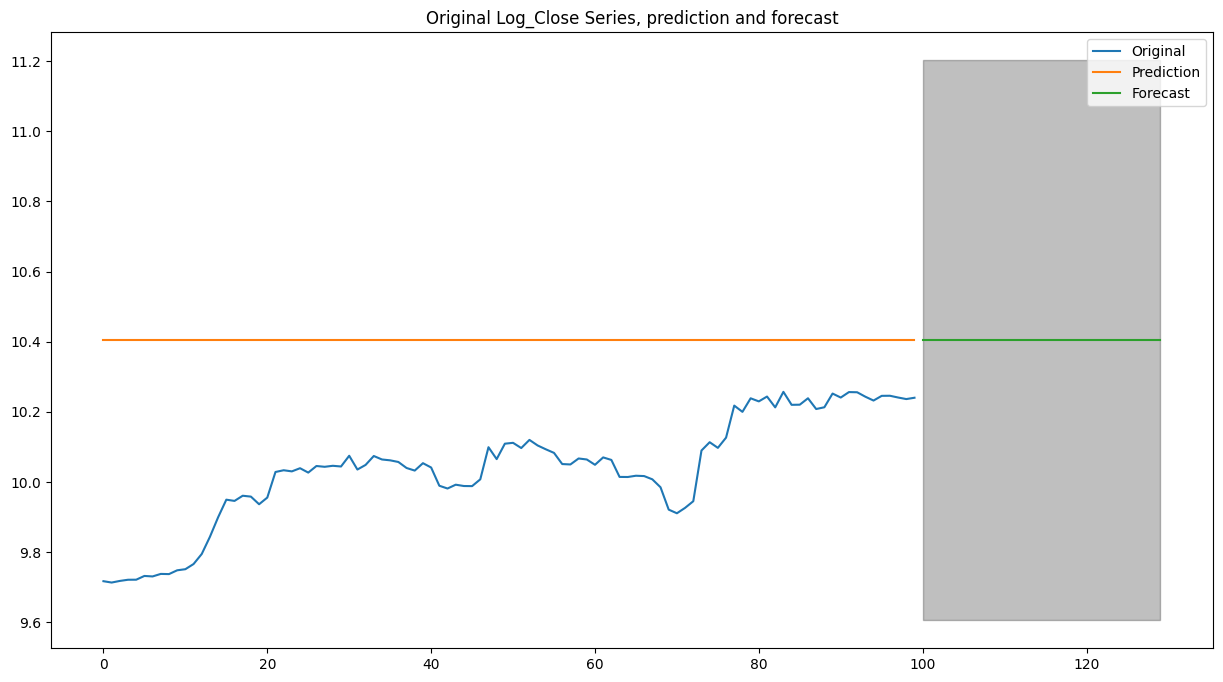

In [32]:
df_to_plot = df_BTC.iloc[-100:]
fitted = model_fit.fittedvalues[-100:]
steps = 30
forecasted = model_fit.get_forecast(steps=steps)


fig, axes = plt.subplots(1, 1, figsize=(15, 8))

orig_x_axis = list(range(len(df_to_plot)))
full_x_axis = list(range(len(df_to_plot) + steps))

axes.plot(orig_x_axis, df_to_plot[serie].values, label="Original")
axes.plot(orig_x_axis, fitted, label="Prediction")
axes.plot(full_x_axis[-steps:], forecasted.predicted_mean, label="Forecast")
axes.fill_between(
    full_x_axis[-steps:],
    forecasted.conf_int()[:, 0],
    forecasted.conf_int()[:, 1],
    color="k",
    alpha=0.25,
)
axes.set_title(f"Original {serie} Series, prediction and forecast")
axes.legend()

## SARIMA Modeling


Although $p$, $d$, $q$ remain the same, we have to find the same for the seasonal component $P$, $D$, $Q$ parameter to give to the **SARIMAX** model. To do so we will extract the seasonal component from the series using the `seasonal_compose` function from `statsmodels`


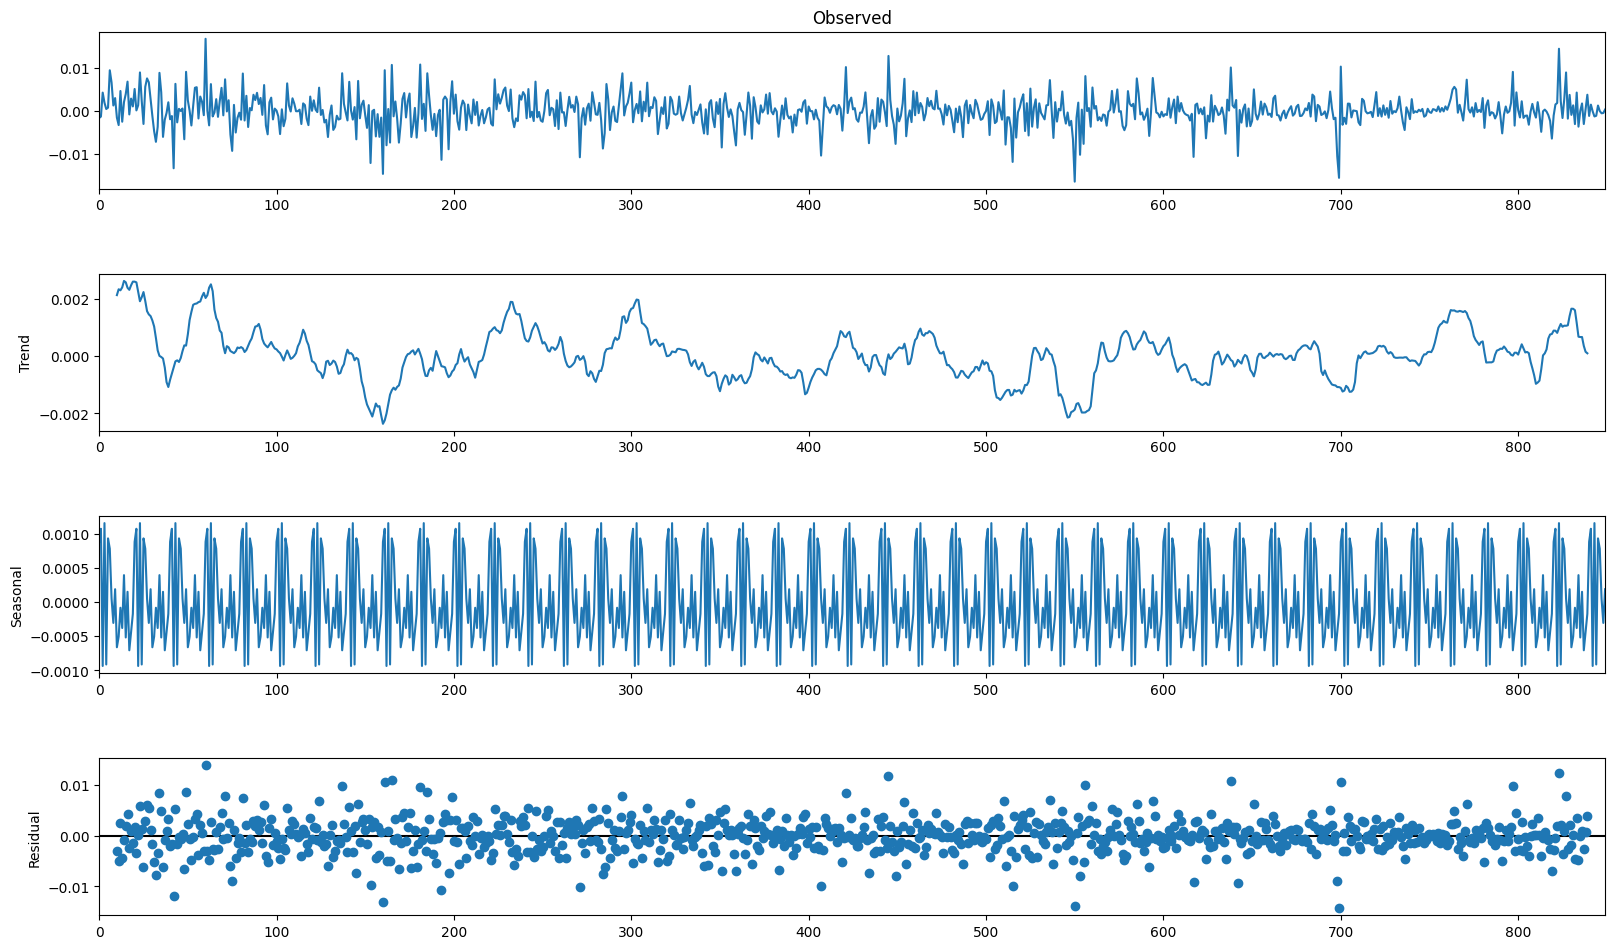

In [120]:
from statsmodels.tsa.seasonal import seasonal_decompose


result = seasonal_decompose(df_BTC[serie].values, model="additive", period=20)
fig = result.plot()
fig.set_size_inches(18.5, 10.5)

In [125]:
season = pd.Series(result.seasonal, name="seasonal")

### Finding $D$


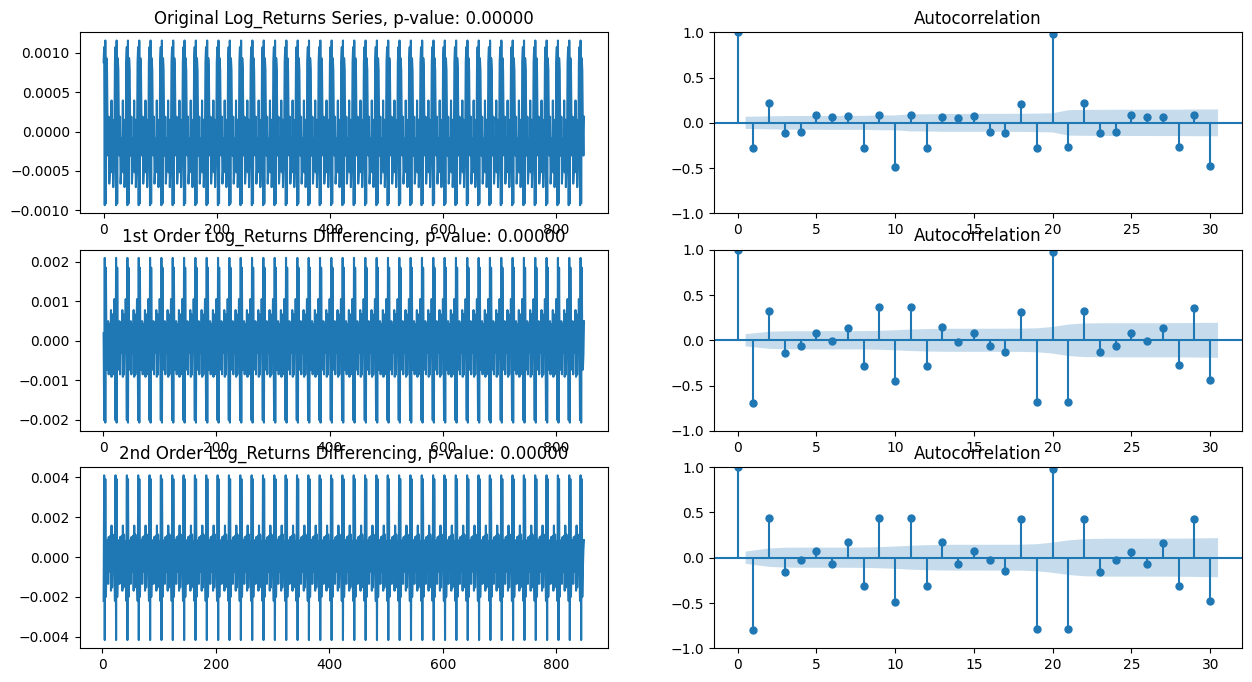

In [126]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


# Original Series
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes[0, 0].plot(season.index, season)
axes[0, 0].set_title(
    f"Original {serie} Series, p-value: {adfuller(season.values)[1]:.5f}"
)
plot_acf(season, ax=axes[0, 1])

# 1st Differencing
diff = season.diff().dropna()
axes[1, 0].plot(diff.index, diff)
axes[1, 0].set_title(
    f"1st Order {serie} Differencing, p-value: {adfuller(diff.values)[1]:.5f}"
)
plot_acf(diff.dropna(), ax=axes[1, 1])

# 2nd Differencing
diff_diff = diff.diff().dropna()
axes[2, 0].plot(diff_diff.index, diff_diff)
axes[2, 0].set_title(
    f"2nd Order {serie} Differencing, p-value: {adfuller(diff_diff.values)[1]:.5f}"
)
plot_acf(diff_diff.dropna(), ax=axes[2, 1])

plt.show()

### Finding $P$


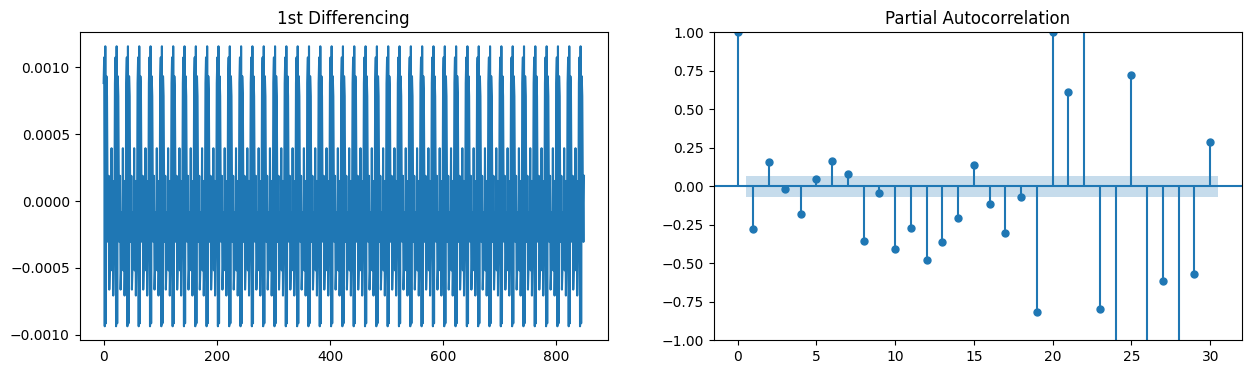

In [128]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(season.index, season.values)
axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0, 5))
plot_pacf(season, ax=axes[1])

plt.show()

### Finding $Q$


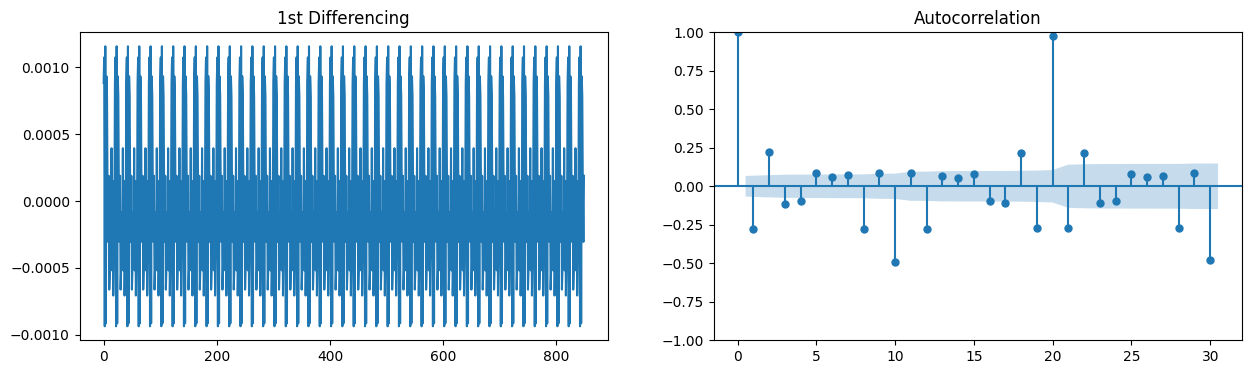

In [129]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
axes[0].plot(season.index, season.values)
axes[0].set_title("1st Differencing")
axes[1].set(ylim=(0, 5))
plot_acf(season, ax=axes[1])

plt.show()

In [132]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    df_BTC[serie].values, order=(0, 2, 2), seasonal_order=(2, 0, 3, 30 * 12)
)  # (P,D,Q,s)
sarimax_model_fitted = sarimax_model.fit()
print(model_fit.summary())

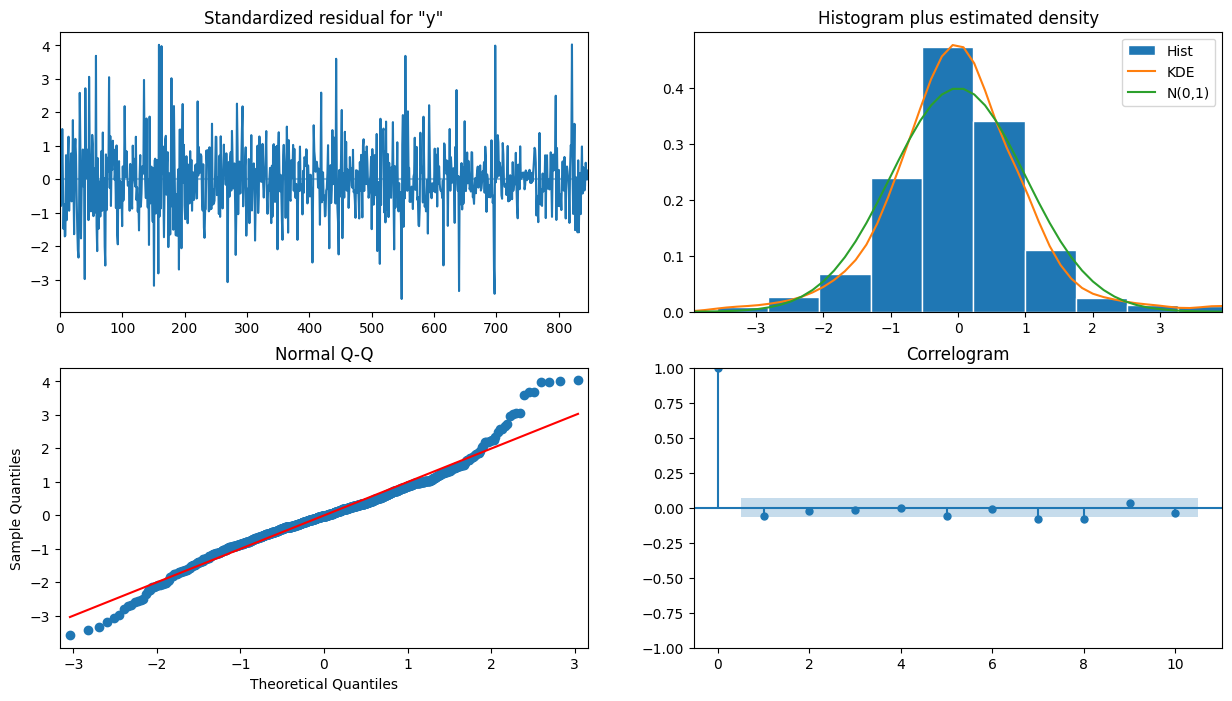

In [93]:
sarimax_model_fitted.plot_diagnostics(figsize=(15, 8))
plt.show()


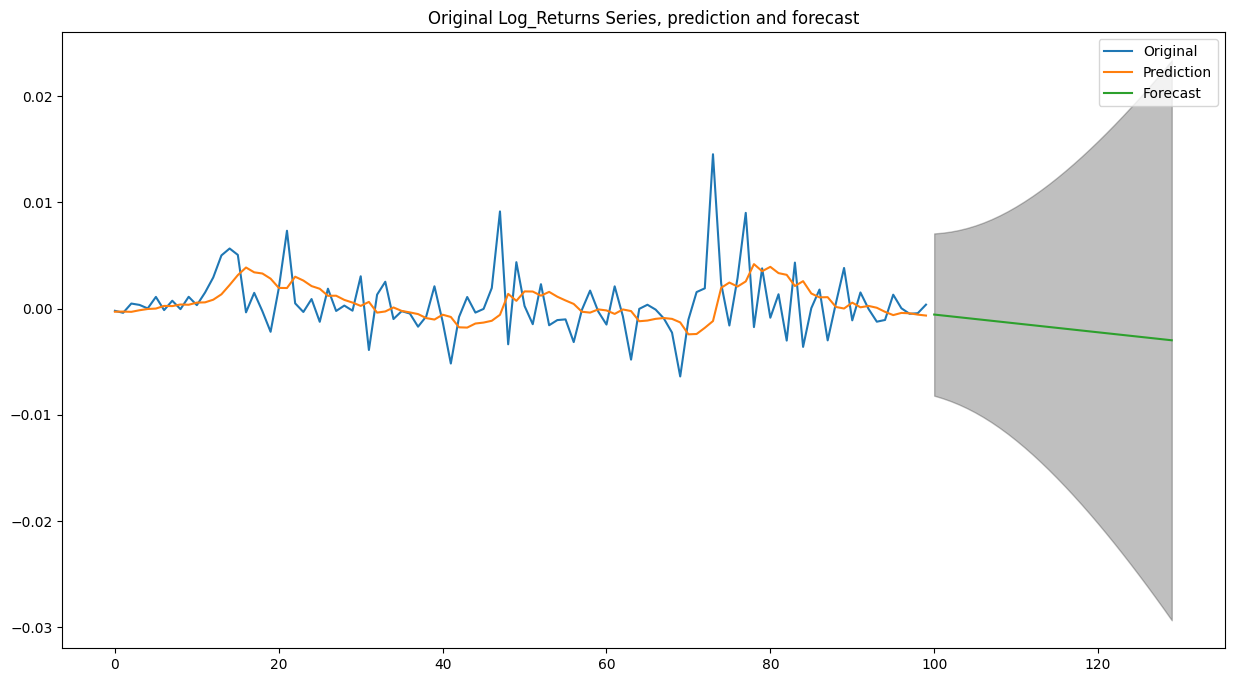

In [94]:
df_to_plot = df_BTC.iloc[-100:]
fitted = sarimax_model_fitted.fittedvalues[-100:]
steps = 30
forecasted = sarimax_model_fitted.get_forecast(steps=steps)


fig, axes = plt.subplots(1, 1, figsize=(15, 8))

orig_x_axis = list(range(len(df_to_plot)))
full_x_axis = list(range(len(df_to_plot) + steps))

axes.plot(orig_x_axis, df_to_plot[serie].values, label="Original")
axes.plot(orig_x_axis, fitted, label="Prediction")
axes.plot(full_x_axis[-steps:], forecasted.predicted_mean, label="Forecast")
axes.fill_between(
    full_x_axis[-steps:],
    forecasted.conf_int()[:, 0],
    forecasted.conf_int()[:, 1],
    color="k",
    alpha=0.25,
)
axes.set_title(f"Original {serie} Series, prediction and forecast")
axes.legend()

# ARCH, GARCH

# Theta Model

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from quant_invest_lab.data_provider import download_crypto_historical_data


In [2]:
symbol= 'BTC-USDT'

df_BTC = download_crypto_historical_data(symbol,'1hour').iloc[-3000:]
df_BTC["Return"] = df_BTC.Close.pct_change()
df_BTC.dropna(inplace=True)
print(df_BTC.shape)
df_BTC.head()

train = df_BTC[:df_BTC.shape[0]//2]
test = df_BTC[df_BTC.shape[0]//2:]
df_BTC.head()

(2999, 9)


,Timestamp,Open,Close,High,Low,Amount,Volume,Returns,Return
Date,,,,,,,,,
2023-01-13 16:00:00,1.673622e+09,18998.9,19260.5,19309.5,18993.4,1160.606223,2.224767e+07,0.013769,0.013769
2023-01-13 17:00:00,1.673626e+09,19260.6,19131.2,19271.6,19064.0,427.925713,8.189067e+06,-0.006713,-0.006713
2023-01-13 18:00:00,1.673629e+09,19131.2,19256.2,19392.2,19106.7,485.314231,9.359598e+06,0.006534,0.006534
2023-01-13 19:00:00,1.673633e+09,19256.2,19292.8,19384.4,19256.1,249.704990,4.822401e+06,0.001901,0.001901
2023-01-13 20:00:00,1.673636e+09,19292.8,19360.6,19369.0,19247.7,222.083237,4.286924e+06,0.003514,0.003514


In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.theta import ThetaModel


def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len

    if method == 'last_season':
        pred_last_season = []
        
        for i in range(train_len, total_len, window):
            last_season = df['Close'][:i].iloc[-window:].values
            pred_last_season.extend(last_season)
            
        return pred_last_season
    
    elif method == 'theta':
        pred_theta = []
        
        for i in range(train_len, total_len, window):
            tm = ThetaModel(endog=df['Close'][:i], period=52)
            res = tm.fit()
            predictions = res.forecast(window)
            pred_theta.extend(predictions)
            
        #print(res.summary())

        return pred_theta
              
    elif method == 'tes':
        pred_tes = []
        
        for i in range(train_len, total_len, window):
            tes = ExponentialSmoothing(
                df['Close'][:i],
                trend='add',
                seasonal='add',
                seasonal_periods=52,
                initialization_method='estimated'
            ).fit()
            
            predictions = tes.forecast(window)
            pred_tes.extend(predictions)

    return pred_tes

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 50

pred_last_season = rolling_forecast(df_BTC, TRAIN_LEN, HORIZON, WINDOW, 'last_season')[:len(test)]
pred_theta = rolling_forecast(df_BTC, TRAIN_LEN, HORIZON, WINDOW, 'theta')[:len(test)]
pred_tes = rolling_forecast(df_BTC, TRAIN_LEN, HORIZON, WINDOW, 'tes')[:len(test)]

test = test.copy()

test['pred_last_season'] = pred_last_season# [:-(len(pred_last_season)-len(test))]
test['pred_theta'] = pred_theta# [:-(len(pred_theta)-len(test))]
test['pred_tes'] = pred_tes# [:-(len(pred_tes)-len(test))]

test.head()